In [1]:
import numpy as np
import dedalus.public as d3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

plt.style.use('/mnt/c/Ryan_Data/Python_Tool/ryan_mplstyle.mplstyle')

In [2]:
# Physical Parameters
xin2 = 1/2
Ub = 1
delta = 0.2

# Numerics Parameters
Lz = 1
Nz = 128

dtype = np.complex128

# Bases
Lzt, Lzb = 0, -Lz

coords = d3.CartesianCoordinates('z')
dist = d3.Distributor(coords, dtype=dtype)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(Lzb, Lzt))

In [3]:
# Fields
N2 = dist.Field(bases=zbasis )
U_M = dist.Field(bases=zbasis )
By_M = dist.Field(bases=zbasis )
Qy_M = dist.Field(bases=zbasis )

In [4]:
# Substitutions
dz = lambda A: d3.Differentiate(A, coords['z'])

In [48]:
# Problem
problem_mean = d3.LBVP([By_M, Qy_M], namespace=locals())

problem_mean.add_equation("By_M = -dz(U_M)")
problem_mean.add_equation("Qy_M = 0*xin2-Ub*dz(1/N2*dz(U_M))")

{'LHS': <Field 139788839907680>,
 'RHS': Mul(-1, Diff(Mul(Pow(<Field 139788839911280>, -1), Diff(<Field 139788839899520>)))),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'L': Convert(<Field 139788839907680>),
 'F': Mul(-1, Diff(Mul(Pow(<Field 139788839911280>, -1), Diff(<Field 139788839899520>)))),
 'domain': <dedalus.core.domain.Domain at 0x7f2320255570>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [56]:
z = dist.local_grids(zbasis)[0]

N2['g'] = np.exp(z/delta)
U_M['g'] = (1+z-delta)*np.exp(z/delta)/5

# N2['g']  = 1
# U_M['g'] = -(z**2/2+z+1/2)

In [57]:
# Solver
solver_mean = problem_mean.build_solver()
solver_mean.solve()

2023-10-25 09:46:12,284 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+02/s


In [58]:
Qy_M['g'] = Qy_M['g'][int(Nz/2)]

print(Qy_M['g'][0])

(-0.9999999999984133+0j)


/home/ryan_wsl2/mambaforge/envs/dedalus3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


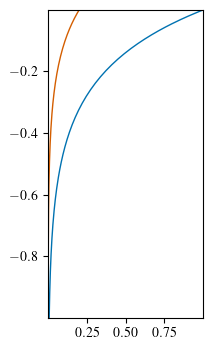

In [32]:
fig=plt.figure(figsize=(2,4))

# plt.plot(Qy_M['g'],z)
plt.plot(N2['g'],z)
plt.plot(U_M['g'],z)

In [33]:
# Fields
omega = dist.Field()

q = dist.Field(name='q', bases=zbasis )
bt = dist.Field(name='bt' )
bb = dist.Field(name='bb' )

P0 = dist.Field(name='P0', bases=zbasis )

tau_P0 = dist.Field()
tau_P0t = dist.Field( )
tau_P0b = dist.Field( )

kx = dist.Field(name='kx')
ky = dist.Field(name='ky')
omega = dist.Field()

# Substitutions
dx = lambda A: 1j*kx*A
dy = lambda A: 1j*ky*A
# dz = lambda A: d3.Differentiate(A, coords['z'])
dt = lambda A: -1j*omega*A

z = dist.local_grids(zbasis)

lift_basis = zbasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

u = -dy(P0)
v =  dx(P0)

ut = u(z=Lzt); vt = v(z=Lzt); 
ub = u(z=Lzb); vb = v(z=Lzb); 

By_Mt = By_M(z=Lzt); By_Mb = By_M(z=Lzb)
U_Mt = U_M(z=Lzt);   U_Mb = U_M(z=Lzb)

lap = lambda A: dx(dx(A))+dy(dy(A))

# print(By_Mt.evaluate()['g'])

In [34]:
# Problem
problem = d3.EVP([P0, tau_P0t, tau_P0b, \
                  q, bt\
                  ], eigenvalue=omega, namespace=locals())

problem.add_equation("lap(P0) + Ub*dz( 1/N2*dz(P0) ) + lift(tau_P0t,-1) + lift(tau_P0b,-2) - q = 0")
problem.add_equation("dz(P0)(z=Lzt) - bt = 0"); problem.add_equation("dz(P0)(z=Lzb) - 0 = 0")

problem.add_equation("dt(bt) + U_Mt*dx(bt) + vt*By_Mt = 0")
# problem.add_equation("dt(bb) + U_Mb*dx(bb) + vb*By_Mb = 0")

problem.add_equation("dt(q) + U_M*dx(q) + v*Qy_M = 0")

{'LHS': Add(Add(Mul(Mul((-0-1j), <Field 139788663275872>), <Field 139788663282112>), Mul(<Field 139788839899520>, Mul(Mul(1j, <Field 139788663275824>), <Field 139788663282112>))), Mul(Mul(Mul(1j, <Field 139788663275824>), <Field 139788663281152>), <Field 139788839907680>)),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'M': Mul((-0-1j), <Field 139788663282112>),
 'L': Add(Mul(<Field 139788839899520>, Mul(Mul(1j, <Field 139788663275824>), <Field 139788663282112>)), Mul(Mul(Mul(1j, <Field 139788663275824>), <Field 139788663281152>), <Field 139788839907680>)),
 'domain': <dedalus.core.domain.Domain at 0x7f23202569b0>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [35]:
By_Mt.evaluate()['g']

array([-1.2+0.j])

In [36]:
# Solver
k_ary = np.exp(np.arange(-1.5,4,0.2))
grow_ary = np.empty([k_ary.size])
c_ary_1 = np.empty([k_ary.size], dtype=complex)
c_ary_2 = np.empty([k_ary.size], dtype=complex)

for ix in range(k_ary.size):
    kx['g'] = k_ary[ix]; ky['g'] = 0

    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
    evals = solver.eigenvalues
    # print(evals.shape)

    e_loc = np.argmax(np.imag(evals))
    grow_ary[ix] = np.imag(evals[e_loc])
    
    if abs(np.imag(evals[e_loc])) > 1e-15:
        c_ary_1[ix] = evals[e_loc]/k_ary[ix]
        c_ary_2[ix] = evals[e_loc]/k_ary[ix]
    else:
        c_ary_1[ix] = np.min(evals[evals<np.inf])/k_ary[ix]
        c_ary_2[ix] = np.max(evals[evals<np.inf])/k_ary[ix]

2023-10-25 09:43:18,481 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2023-10-25 09:43:18,698 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2023-10-25 09:43:18,946 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s
2023-10-25 09:43:19,183 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s
2023-10-25 09:43:19,434 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2023-10-25 09:43:19,683 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2023-10-25 09:43:19,938 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+01/s
2023-10-25 09:43:20,177 subsystems 0/1 INFO :: Building subproblem matrices 

(0.22313016014842982, 20)

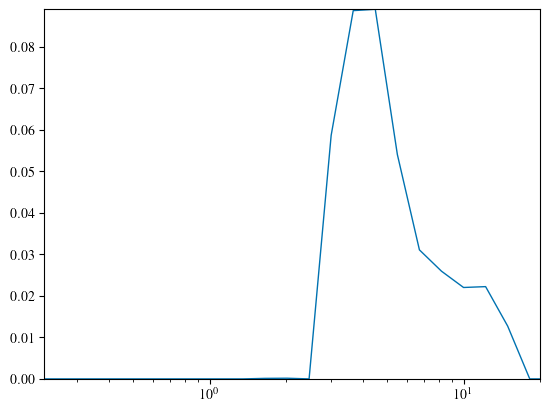

In [37]:
plt.semilogx(k_ary,grow_ary)
plt.xlim(np.exp(-1.5),20)

In [38]:
k_max = k_ary[np.argmax(grow_ary)]
kx['g'] = k_max; ky['g'] = 0
# kx['g'] = 3.0; ky['g'] = 0

solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
evals = solver.eigenvalues
# print(evals)

loc_grow = np.argmax(np.imag(evals))

2023-10-25 09:43:29,789 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s


In [39]:
solver.set_state(loc_grow,0)

P0_evec = solver.state[0]['g'] # index 0 because P0 is the first element of the d3.EVP statement

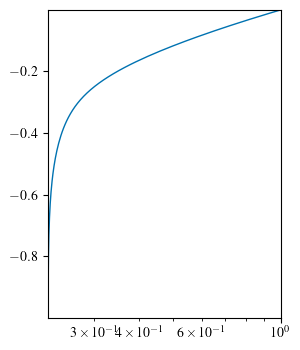

In [40]:
# plot
fig=plt.figure(figsize=(3,4))

plt.semilogx(np.abs(P0_evec)/np.abs(P0_evec[-1]),z[0].ravel())
# plt.xlim(0.5,1)

In [41]:
x = np.arange(0,3*np.pi,0.05)
phs_corr = np.exp(1j*1.5*x)

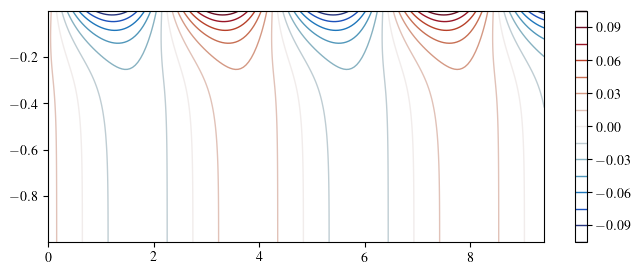

In [42]:
P0eig_mat = np.outer(P0_evec,phs_corr)
fig=plt.figure(figsize=(8,3))

plt.contour(x,z[0].ravel(),P0eig_mat.real, 13, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.colorbar()

In [43]:
b = dist.Field(bases=zbasis )
v = dist.Field(bases=zbasis )

In [44]:
# Problem
problem_morefields = d3.LBVP([v, b], namespace=locals())

problem_morefields.add_equation("v = dx(P0)")
problem_morefields.add_equation("b = dz(P0)")

{'LHS': <Field 139788657085504>,
 'RHS': Diff(<Field 139788663281152>),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'L': Convert(<Field 139788657085504>),
 'F': Diff(<Field 139788663281152>),
 'domain': <dedalus.core.domain.Domain at 0x7f2320257760>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [45]:
P0['g'] = P0_evec/np.abs(P0_evec[-1])

In [46]:
# Solver
solver_morefields = problem_morefields.build_solver()
solver_morefields.solve()

2023-10-25 09:43:42,338 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+02/s


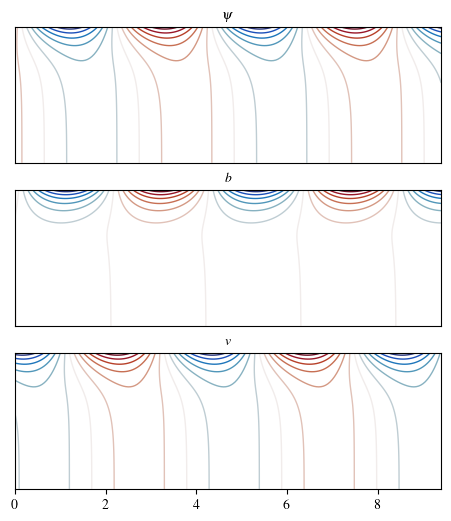

In [47]:
fig=plt.figure(figsize=(5.5,6))

plt.subplot(3,1,1)
P0eig_mat = np.outer(P0['g'],phs_corr)
plt.contour(x,z[0].ravel(),P0eig_mat.real, 14, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.xticks([]); plt.yticks([])
# plt.colorbar()
plt.title("$\psi$")

plt.subplot(3,1,2)
beig_mat = np.outer(b['g'],phs_corr)/np.max(np.abs(b['g']).ravel())
plt.contour(x,z[0].ravel(),beig_mat.real, 14, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.xticks([]); plt.yticks([])
# plt.colorbar()
plt.title("$b$")

plt.subplot(3,1,3)
veig_mat = np.outer(v['g'],phs_corr)/np.max(np.abs(v['g']).ravel())
plt.contour(x,z[0].ravel(),veig_mat.real, 14, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.yticks([])
# plt.colorbar()
plt.title("$v$")

# plt.savefig("figs/Charney_instabprofile_east.pdf", bbox_inches='tight')
plt.show()